# Datathon Henry

## Análisis exploratorio de datos (EDA)

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from sklearn.cluster import KMeans

Vamos a cargar el modelo y ver sus propiedades

In [7]:
X = pd.read_csv('datasets/properties_colombia_train.csv')
X.head()

,Unnamed: 0,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,...,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type,geometry
0,861131,CScTjaFiP6yCzS8tFX0ZVA==,Propiedad,2020-12-14,9999-12-31,2020-12-14,6.203000,-75.572000,Colombia,Antioquia,...,NaN,NaN,9.000000e+09,COP,NaN,Hermosa Mansión En El Poblado. Área Construida...,<b>Hermosa Mansión En El Poblado. Área Constru...,Casa,Venta,POINT (-75.572 6.203)
1,200972,DlCxox9+FuugkxS2kBVfJg==,Propiedad,2020-09-16,2021-05-14,2020-09-16,4.722748,-74.073115,Colombia,Cundinamarca,...,NaN,NaN,6.250000e+08,COP,NaN,"APARTAMENTO EN VENTA, BOGOTA-CIUDAD JARDIN NORTE",Venta apartamento en piso 16 con vista exterio...,Apartamento,Venta,POINT (-74.0731146 4.7227485)
2,554622,yitN1AigL45gh/K2YSF8rw==,Propiedad,2020-08-19,2020-08-20,2020-08-19,4.709000,-74.030000,Colombia,Cundinamarca,...,NaN,NaN,4.200000e+08,COP,NaN,Apartamento En Venta En Bogota Bella Suiza Cod...,Al entrar a este bonito apartamento interior e...,Casa,Venta,POINT (-74.03 4.709)
3,540321,hELQ9njwODbLMpATXieRdQ==,Propiedad,2020-11-23,2020-11-30,2020-11-23,NaN,NaN,Colombia,Santander,...,NaN,NaN,1.310000e+09,COP,NaN,SE VENDE LOCAL COMERCIAL EN CABECERA DEL LLANO...,Se encuentra ubicado en el sector de la Cabece...,Otro,Venta,POINT EMPTY
4,448920,aBCtKT7LDzt2CxJQ+gVFEA==,Propiedad,2020-10-06,2020-10-07,2020-10-06,NaN,NaN,Colombia,Antioquia,...,NaN,NaN,2.100000e+08,COP,NaN,Apartamento en Venta Ubicado en ITAGUI,Codigo Inmueble 4302 Apartamento con 3 habitac...,Apartamento,Venta,POINT EMPTY


In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197549 entries, 0 to 197548
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       197549 non-null  int64  
 1   id               197549 non-null  object 
 2   ad_type          197549 non-null  object 
 3   start_date       197549 non-null  object 
 4   end_date         197549 non-null  object 
 5   created_on       197549 non-null  object 
 6   lat              148051 non-null  float64
 7   lon              148051 non-null  float64
 8   l1               197549 non-null  object 
 9   l2               197549 non-null  object 
 10  l3               186517 non-null  object 
 11  l4               45367 non-null   object 
 12  l5               27409 non-null   object 
 13  l6               6867 non-null    object 
 14  rooms            27537 non-null   float64
 15  bedrooms         40525 non-null   float64
 16  bathrooms        156467 non-null  floa

### Eliminación inicial de columnas
Revisemos que hay en cada columna. Unnamed: 0 e id son identificadores que no son informativos para la clasificación.

Las columnas que solo tienen un tipo de dato no son de utilizada para la clasificación:

In [9]:
X.nunique()[X.nunique() == 1].index.to_list()

['ad_type', 'l1', 'price_period', 'operation_type']

In [10]:
# aqui notamos además que id y unnamed: 0 no tiene repetidos
X.nunique()

Unnamed: 0         197549
id                 197549
ad_type                 1
start_date            145
end_date              446
created_on            145
lat                 51077
lon                 50108
l1                      1
l2                     31
l3                    293
l4                     58
l5                     20
l6                    146
rooms                  29
bedrooms               37
bathrooms              20
surface_total        1035
surface_covered       783
price                6096
currency                2
price_period            1
title               95025
description        111371
property_type           8
operation_type          1
geometry            62807
dtype: int64

In [11]:
for column in X.columns.tolist():
    if len(X[column].unique()) <= 2:
        print(column,': ', X[column].unique())

ad_type :  ['Propiedad']
l1 :  ['Colombia']
price_period :  [nan 'Mensual']
operation_type :  ['Venta']


`created_on` y `start_date` son la misma columna:

In [12]:
(X.created_on != X.start_date).sum()

0

`geometry` es la latitud y la longitud en una sola columna.

In [13]:
X[['geometry', 'lat', 'lon']].head()

,geometry,lat,lon
0,POINT (-75.572 6.203),6.203000,-75.572000
1,POINT (-74.0731146 4.7227485),4.722748,-74.073115
2,POINT (-74.03 4.709),4.709000,-74.030000
3,POINT EMPTY,NaN,NaN
4,POINT EMPTY,NaN,NaN


De acuerdo a lo anterior, eliminamos: `Unnamed: 0`, `id`, `ad_type`, `l1`, `price_period`, `operation_type`, `created_on`, `geometry`

In [14]:
S = X.nunique()
# columnas con un solo valor único
to_drop = S[S==1].index.to_list()
to_drop

['ad_type', 'l1', 'price_period', 'operation_type']

In [15]:
X.drop(['Unnamed: 0', 'id', 'ad_type', 'l1', 'price_period', 'operation_type', 'created_on', 'geometry'], axis='columns', inplace=True)

In [16]:
X.columns

Index(['start_date', 'end_date', 'lat', 'lon', 'l2', 'l3', 'l4', 'l5', 'l6',
       'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'currency', 'title', 'description', 'property_type'],
      dtype='object')

De las variables que quedaron, start_date, end_date, lat, lon, l2, l3, l4, l5, l6, title, description, property_type son variables cualitativas y rooms, bedrooms, bathrooms, surface_total, surface_covered, price son cuantitativas. Ahora, revisemos valores faltantes:

In [17]:
# porcentaje de nulos
X.isnull().mean()*100

start_date          0.000000
end_date            0.000000
lat                25.056062
lon                25.056062
l2                  0.000000
l3                  5.584437
l4                 77.035065
l5                 86.125468
l6                 96.523900
rooms              86.060674
bedrooms           79.486102
bathrooms          20.795853
surface_total      96.469737
surface_covered    95.038193
price               0.031891
currency            0.033916
title               0.000506
description         0.061251
property_type       0.000000
dtype: float64

Las variables cuantitativas tienen un alto porcentaje de faltantes. Tambien l4 y l5, que son variables relacionadas a la ubicación. Nos quedaremos con dos niveles administrativos por ahora, l2 y l3

In [18]:
X.drop(['l4','l5','l6'], axis='columns',inplace=True)
X.columns

Index(['start_date', 'end_date', 'lat', 'lon', 'l2', 'l3', 'rooms', 'bedrooms',
       'bathrooms', 'surface_total', 'surface_covered', 'price', 'currency',
       'title', 'description', 'property_type'],
      dtype='object')

### Price
Para graficar separando por categoria, hay que normalizar la variable de precio. Primero, cambiamos la variable de precios que esté en USD a COP. El cambio a usar va a ser por fecha. El precio promedio del COP en USD en 2020, que es el único año para el que tenemos datos, fue de 3691.3167 COP = 1 USD.

In [19]:
X.loc[X.currency == 'USD', 'price'] = X.price*3691.3167

Podemos eliminar currency

In [20]:
X.drop(['currency'], axis='columns', inplace=True)

Ahora vamos a visualizar la distribución de precios

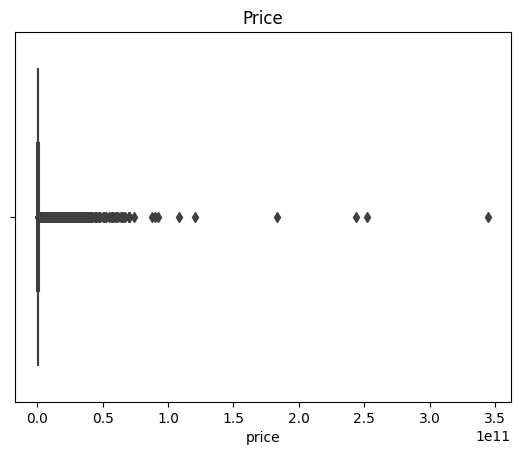

In [21]:
sns.boxplot(data=X, x='price')
plt.title('Price');

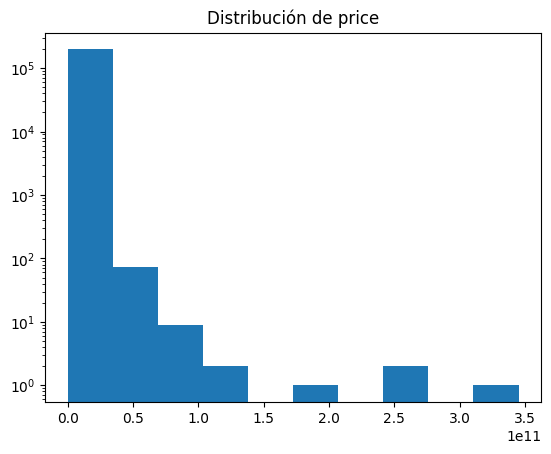

In [22]:
plt.hist(X.price, log=True)
plt.title('Distribución de price');

El rango de precios es muy amplio y la mayoría de los precios se encuentran entre 0 y 1.5. Podemos eliminar outliers para ver si esto mejora la clasificación.

In [23]:
# eliminamos outliers
def delete_outliers(df, column='price'):
    '''
    Elimina outliers en una columna utilizando el IQR.
    '''
    # usamos el iqr
    q1 = df[column].quantile(.25)
    q3 = df[column].quantile(.75)
    iqr = q3-q1

    # definimos los limites
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr

    #filtramos
    filter = (df[column] >= lower) & (df[column] <= upper) | (df[column].isnull())
    df = df.loc[filter]

    return df


In [24]:
X.shape

(197549, 15)

In [25]:
X = delete_outliers(X)
X.shape

(178224, 15)

Rellenamos los precios nulos con la media, ya que no queremos que se altere porque es lo que vamos a usar para clasificar.

In [26]:
def fill_prices(df):
    '''
    Rellena precios nulos con la media.
    '''

    df.loc[df.price.isnull(), 'price'] = df.price.mean()

    return None

In [27]:
X.loc[X.price.isnull(), 'price'] = X.price.mean()
# Vemos que no hay nulos
X.price.isnull().sum() 

0

### Latitud y longitud
Ahora revisaremos los outliers de latitud y longitud.

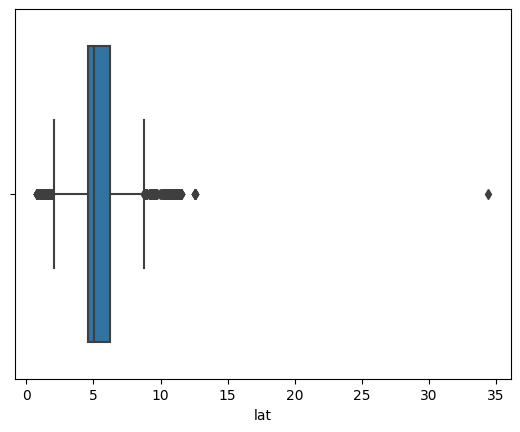

In [28]:
sns.boxplot(data=X, x='lat');

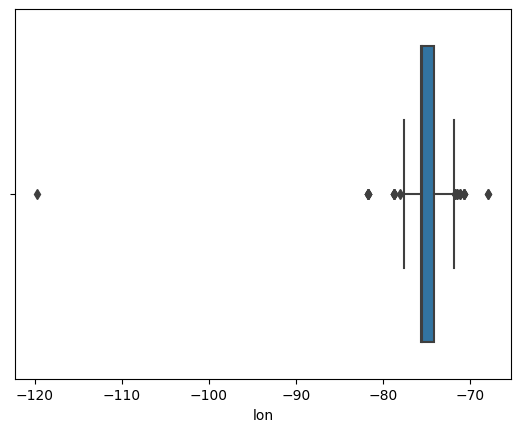

In [29]:
sns.boxplot(data=X, x='lon');

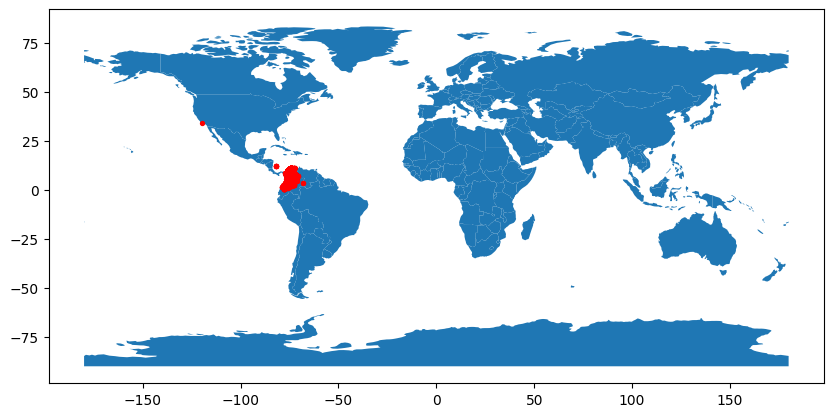

In [30]:
geometry = [Point(xy) for xy in zip(X['lon'], X['lat'])]
gdf = GeoDataFrame(X, geometry=geometry)    

# Ploteamos el mapa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=8);

Vemos al menos 2 punto que se encuentra fuera de Colombia.

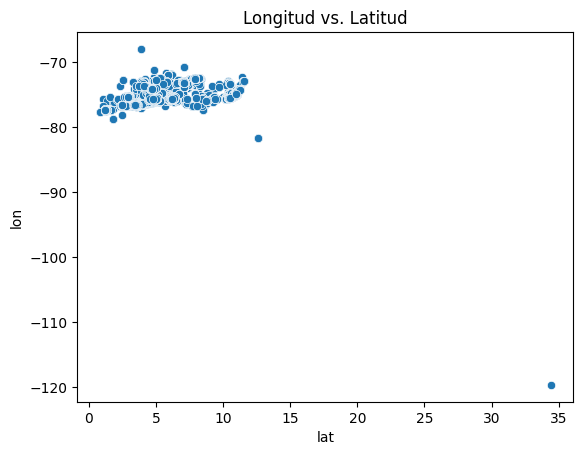

In [31]:
sns.scatterplot(data=X, x='lat', y='lon')
plt.title('Longitud vs. Latitud');

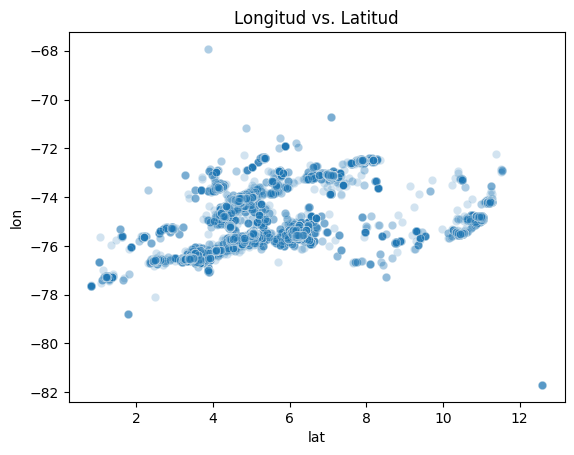

In [32]:
# eliminamos el registo que es evidentemente un outlier (punto en USA en el plot de mapa)
X = X.loc[~(X.lat > 30)]
# X = X.loc[~(X.lat < -20)] # si no elimino outliers de precios, tambien hay un punto en Chile
# ahora la correlacion 
sns.scatterplot(data=X, x='lat', y='lon', alpha=0.2)
plt.title('Longitud vs. Latitud');

Los otros puntos que parecen outliers sí se encuentran en Colombia. Veamos los valores faltantes en latitud y longitud

In [33]:
X.isnull().sum()

start_date              0
end_date                0
lat                 45829
lon                 45829
l2                      0
l3                   9866
rooms              153803
bedrooms           142164
bathrooms           34042
surface_total      172421
surface_covered    170041
price                   0
title                   1
description           112
property_type           0
geometry                0
dtype: int64

In [34]:
X.loc[X.lat.isnull()].l2.unique()

array(['Antioquia', 'Atlántico', 'Cundinamarca', 'Meta',
       'Valle del Cauca', 'Caldas', 'Risaralda', 'Magdalena', 'Santander',
       'Cauca', 'Huila', 'Bolívar', 'Tolima', 'Norte de Santander',
       'Quindío', 'Caquetá', 'Sucre', 'Guainía', 'La Guajira', 'Boyacá',
       'Cesar', 'Amazonas', 'San Andrés Providencia y Santa Catalina',
       'Casanare', 'Vichada', 'Córdoba', 'Chocó'], dtype=object)

Creamos una función para rellenar las latitudes y longitudes faltantes:

In [35]:
def fill_lat_lon(df):

    dict_lat = {
    'Antioquia': 7.154030, 'Atlántico': 10.987760, 'Cundinamarca': 4.781800,
    'Meta': 3.2720, 'Valle del Cauca': 3.858560, 'Caldas': 6.090000,
    'Risaralda': 4.606880, 'Magdalena': 10.249170, 'Santander': -0.622170,
    'Cauca': 8.252500, 'Huila': 3.376450, 'Bolívar': 1.833650, 'Tolima': 4.034880,
    'Norte de Santander': 8.084580, 'Quindío': 4.396070, 'Caquetá': 1.113340,
    'Sucre': 8.811250, 'Guainía': 2.719020, 'La Guajira': 11.427780,
    'Boyacá': 5.453740, 'Cesar': 10.769930, 'Amazonas': -2.056290,
    'San Andrés Providencia y Santa Catalina': 12.542720, 'Casanare': 5.296580,
    'Vichada': 4.712170, 'Córdoba': 9.586680, 'Chocó': 6.320330
    }

    dict_lon = {
    'Antioquia': -75.503349, 'Atlántico': -74.954620, 'Cundinamarca': -73.970757,
    'Meta': -73.0877, 'Valle del Cauca': -76.519810, 'Caldas': -75.636627,
    'Risaralda': -74.071840, 'Magdalena': -74.261080, 'Santander': -72.382812,
    'Cauca': -74.722893, 'Huila': -74.802391, 'Bolívar': -76.967293, 'Tolima': -75.255890, 
    'Norte de Santander': -72.842781, 'Quindío': -75.640083, 'Caquetá': -73.813004, 
    'Sucre': -74.721390, 'Guainía': -67.566940, 'La Guajira': -72.388634,
    'Boyacá': -73.362480, 'Cesar': -73.004791, 'Amazonas': -71.892921,
    'San Andrés Providencia y Santa Catalina': -81.717900, 'Casanare': -71.456268,
    'Vichada': -69.414350, 'Córdoba': -74.826302, 'Chocó': -76.944901
    }
    df.lat = np.where(df.lat.isnull(), df.l2.map(dict_lat), df.lat)
    df.lon = np.where(df.lon.isnull(), df.l2.map(dict_lon), df.lon)

    return None

Rellenamos valores faltantes utilizando los diccionarios asociados a l2.

In [36]:
fill_lat_lon(X)
# Vemos que no hay nulos en lat y lon
X[['lat','lon']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178223 entries, 1 to 197548
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   lat     178223 non-null  float64
 1   lon     178223 non-null  float64
dtypes: float64(2)
memory usage: 4.1 MB


Vemos nuevamente el mapa:

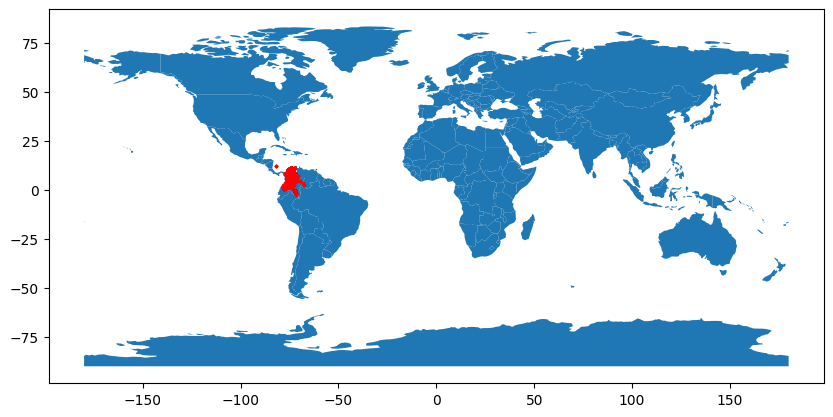

In [37]:
geometry = [Point(xy) for xy in zip(X['lon'], X['lat'])]
gdf = GeoDataFrame(X, geometry=geometry)    

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=2);

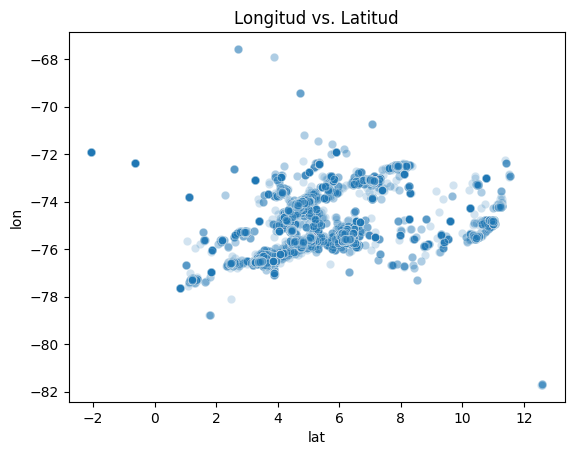

In [38]:
sns.scatterplot(data=X, x='lat', y='lon', alpha=0.2)
plt.title('Longitud vs. Latitud');

### Fechas
Ahora procesamos las fechas

In [39]:
X.start_date = pd.to_datetime(X.start_date)
max_month = X.start_date.dt.month.max()
min_month = X.start_date.dt.month.min()
print('Tenemos registros de 2020 desde el mes {} hasta el mes {}'.format(min_month, max_month))

Tenemos registros de 2020 desde el mes 7 hasta el mes 12


In [40]:
# Se podría calcular los dias que estuvo activa la publicación
X.end_date = pd.to_datetime(X.end_date, errors='coerce')
X['ad_time'] = X.end_date - X.start_date
X['ad_time'] = X['ad_time'].dt.days

In [41]:
# Rellenamos los faltantes, que son los que no se han vendido (?)
X.loc[X.ad_time.isnull(),'ad_time'] = 9999
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178223 entries, 1 to 197548
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   start_date       178223 non-null  datetime64[ns]
 1   end_date         168004 non-null  datetime64[ns]
 2   lat              178223 non-null  float64       
 3   lon              178223 non-null  float64       
 4   l2               178223 non-null  object        
 5   l3               168357 non-null  object        
 6   rooms            24420 non-null   float64       
 7   bedrooms         36059 non-null   float64       
 8   bathrooms        144181 non-null  float64       
 9   surface_total    5802 non-null    float64       
 10  surface_covered  8182 non-null    float64       
 11  price            178223 non-null  float64       
 12  title            178222 non-null  object        
 13  description      178111 non-null  object        
 14  property_type    178

De la fecha de inicio podemos extraer el mes

In [42]:
X['month_start'] = X.start_date.dt.month
X.drop(['start_date','end_date'], axis='columns', inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178223 entries, 1 to 197548
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   lat              178223 non-null  float64 
 1   lon              178223 non-null  float64 
 2   l2               178223 non-null  object  
 3   l3               168357 non-null  object  
 4   rooms            24420 non-null   float64 
 5   bedrooms         36059 non-null   float64 
 6   bathrooms        144181 non-null  float64 
 7   surface_total    5802 non-null    float64 
 8   surface_covered  8182 non-null    float64 
 9   price            178223 non-null  float64 
 10  title            178222 non-null  object  
 11  description      178111 non-null  object  
 12  property_type    178223 non-null  object  
 13  geometry         178223 non-null  geometry
 14  ad_time          178223 non-null  float64 
 15  month_start      178223 non-null  int64   
dtypes: float64(9), geome

### Variables en string
Revisamos la columna de `title`.

In [43]:
# algunos titulos tienen el area total
X.title.loc[399]

'Espectacular Cabaña En Santa Helena En Parcelación. Área Total. 850m2'

In [44]:
X.loc[X.title.str.contains('Área', na=False)].title

399       Espectacular Cabaña En Santa Helena En Parcela...
3061      Hermosos Lotes Disponibles En Condominio, Área...
3593      Vendo Apartamento Sexto Piso Área 62 m²  Rincó...
3929      Vendo Apartamento Primer Piso Área 72 m²  Caba...
6416      Vendo Apartamento Primer Piso Área 70 m²  Vill...
                                ...                        
187805    Espectacular Casa - Finca En San Jose. Área To...
192837    Vendo Local Comercial Área 13 m²  Ubicado En I...
193842    Venta de Lote en Tulua vía La Rivera El Picach...
194274    Espectacular Finca - Sector Aeropuerto. Área T...
194331         Apartamento Medellín El Poblado. Área 236 m2
Name: title, Length: 100, dtype: object

In [45]:
# formateamos str
X.title = X.title.str.capitalize().str.strip()
# eliminamos tildes
X.title = X.title.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [46]:
X.loc[X.title.str.contains('area', na=False)].title

219       Id. 011. lote,  venta en  via potrerito-jamund...
399       Espectacular cabana en santa helena en parcela...
1724      Ideal para lotear, en venta finca en paluato a...
1756      Id. 011. lote,  venta en  via potrerito-jamund...
2628                   Venta apartamento ceiba 2 area 107m2
                                ...                        
193842    Venta de lote en tulua via la rivera el picach...
194266                     Venta finca lebrija 10 hectareas
194274    Espectacular finca - sector aeropuerto. area t...
194331         Apartamento medellin el poblado. area 236 m2
197415    Vendo local-oficina bucaramanga carrera 33 are...
Name: title, Length: 413, dtype: object

Estos datos no representan ni el 1% de datos con el área total o de construcción, por lo que se elimina esta columna.

In [47]:
X.drop(['title'], axis='columns', inplace=True)

Veamos `description`:

In [48]:
# formateamos str
X.description = X.description.str.capitalize().str.strip()
# eliminamos tildes
X.description = X.description.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [49]:
X.loc[X.description.str.contains('bano', na=False)].description.shape

(123015,)

In [50]:
searchfor = ['habitacion','cuarto','pieza']
X.loc[X.description.str.contains('|'.join(searchfor), na=False)].description.shape

(90560,)

In [51]:
searchfor = ['area']
X.loc[X.description.str.contains('|'.join(searchfor), na=False)].description.shape

(46137,)

Baños es la unica variable que vale la pena rellenar. Hago una función para obtener la cantidad de baños de la columna `description` y luego rellenar los que no hayamos obtenido con la moda por tipo de propiedad:

In [52]:
def get_number_bathrooms(df):
    # formateamos str
    df.description = df.description.str.capitalize().str.strip()
    # eliminamos tildes
    df.description = df.description.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

    # Rellenamos las filas sin descripcion
    df.loc[df.description.isnull(), 'description'] = 'No description'
    
    # Cambiamos los numeros escritos por numeros
    dict_num = {' uno ': ' 1 ', ' dos ':' 2 ', ' tres ':' 3 ', 
                ' cuatro ':' 4 ', ' cinco ':' 5 ', ' seis ':' 6 ', 
                ' siete ':' 7 ', ' ocho ':' 8 ', ' nueve ':' 9 '}
                
    for old, new in dict_num.items():
        df.description = df.description.str.replace(old, new, regex=False)

    # Extraigo el numero de strings como "n banos"
    pat = f"(\d+)[\s-](?:{'bano'})"
    bathrooms = df.loc[df.bathrooms.isnull()].description.str.extract(pat)

    df = df.join(bathrooms)
    # donde hay nulos, sustituimos por el numero de baños hallado en description
    df.loc[(df.bathrooms.isnull()) & (df[0].notnull()), 'bathrooms'] = df[0]
    
    # Dropeo la columna agregada para la sustitución
    df.drop([0], axis='columns',inplace=True)

    # Rellenamos los que hayan quedado como nulos con la moda por tipo de propiedad
    moda_bath = df.groupby(['property_type']).bathrooms.agg(pd.Series.mode)
    # los parqueaderos parecen no tener baño
    moda_bath.loc['Parqueadero'] = 0

    # Sustituimos con la moda
    df.bathrooms =  np.where(df.bathrooms.isnull(), df.property_type.map(moda_bath), df.bathrooms)
    df.bathrooms = df.bathrooms.astype(int)

    return df
    

In [53]:
X = get_number_bathrooms(X)
X.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178223 entries, 1 to 197548
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   lat              178223 non-null  float64 
 1   lon              178223 non-null  float64 
 2   l2               178223 non-null  object  
 3   l3               168357 non-null  object  
 4   rooms            24420 non-null   float64 
 5   bedrooms         36059 non-null   float64 
 6   bathrooms        178223 non-null  int32   
 7   surface_total    5802 non-null    float64 
 8   surface_covered  8182 non-null    float64 
 9   price            178223 non-null  float64 
 10  description      178223 non-null  object  
 11  property_type    178223 non-null  object  
 12  geometry         178223 non-null  geometry
 13  ad_time          178223 non-null  float64 
 14  month_start      178223 non-null  int64   
dtypes: float64(8), geometry(1), int32(1), int64(1), object(4)
memory usa

Eliminamos las columnas de `rooms`, `bedrooms`, `surface_total` y `surface_covered` ya que no hay suficiente información para rellenarlas, y `description`, que ya la utilizamos.

In [54]:
X.drop(['rooms','bedrooms','surface_total','surface_covered','description'], axis='columns', inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178223 entries, 1 to 197548
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   lat            178223 non-null  float64 
 1   lon            178223 non-null  float64 
 2   l2             178223 non-null  object  
 3   l3             168357 non-null  object  
 4   bathrooms      178223 non-null  int32   
 5   price          178223 non-null  float64 
 6   property_type  178223 non-null  object  
 7   geometry       178223 non-null  geometry
 8   ad_time        178223 non-null  float64 
 9   month_start    178223 non-null  int64   
dtypes: float64(4), geometry(1), int32(1), int64(1), object(3)
memory usage: 18.3+ MB


### Variables categóricas
Podemos ver la distribución del tipo de propiedad

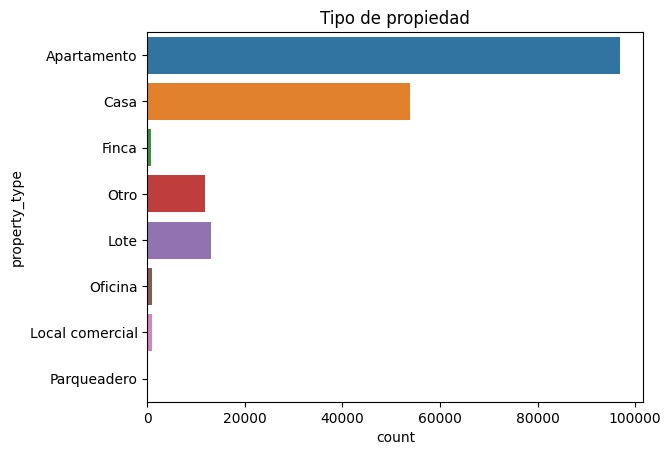

In [55]:
sns.countplot(data=X, y='property_type')
plt.title('Tipo de propiedad');

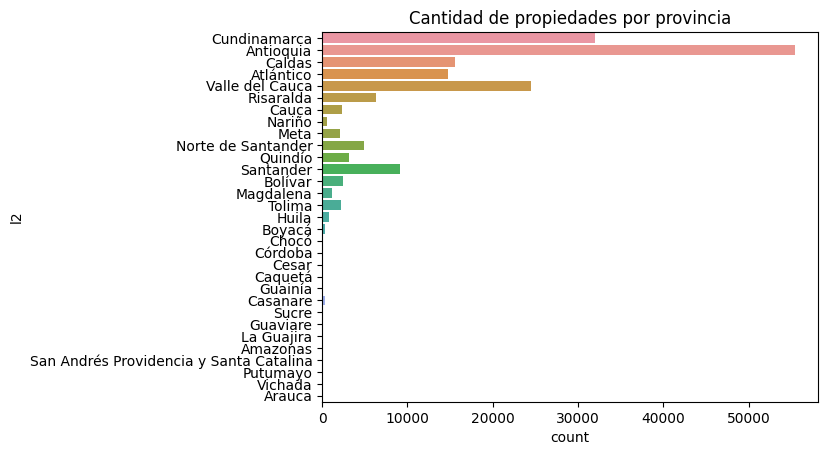

In [61]:
sns.countplot(data=X, y='l2')
plt.title('Cantidad de propiedades por provincia');

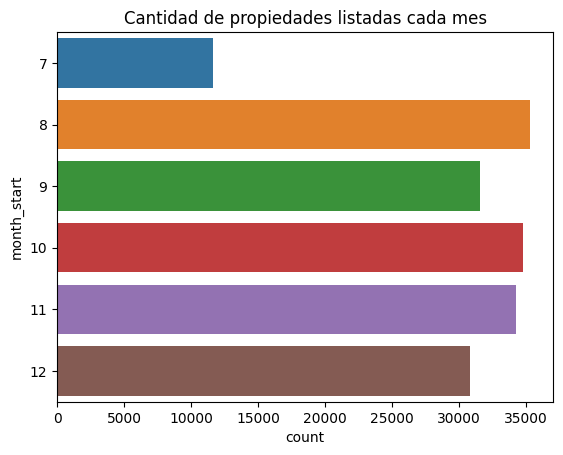

In [64]:
sns.countplot(data=X, y='month_start')
plt.title('Cantidad de propiedades listadas cada mes');

### Agrupamiento de latitud y longitud
Vamos a hacer grupos con latitud y longitud

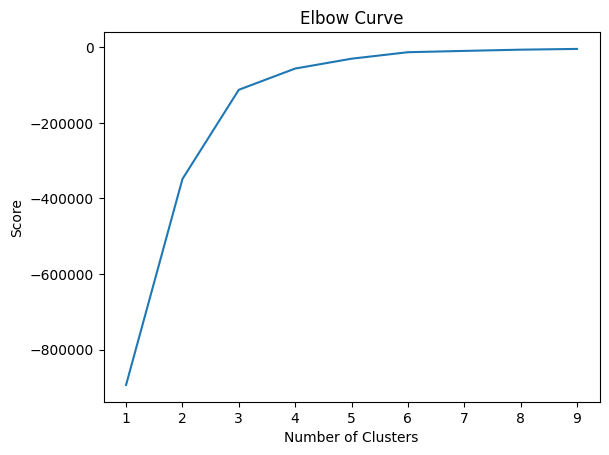

In [56]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = X[['lat']]
X_axis = X[['lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [57]:
kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(X[X.columns[0:2]]) 
X['position_id'] = kmeans.fit_predict(X[X.columns[0:2]])
centers = kmeans.cluster_centers_ 
labels = kmeans.predict(X[X.columns[0:2]]) # Etiqueta de cada punto

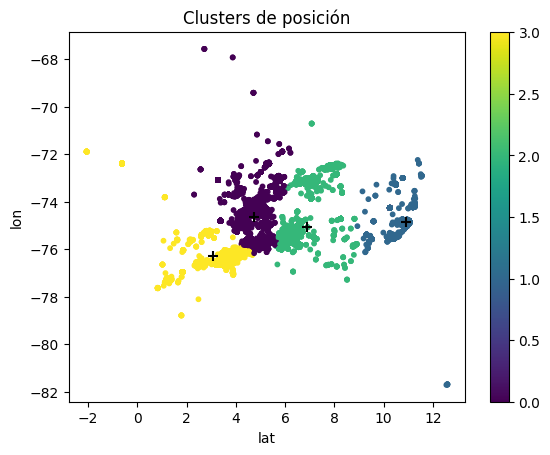

In [58]:
X.plot.scatter(x = 'lat', y = 'lon', c=labels, s=10, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=50, marker='+')
plt.title('Clusters de posición');

### Tasa de criminalidad
Podemos agregar la tasa de criminalidad por provincia de hallada en [este link](https://cej.org.co/indicadores-de-justicia/criminalidad/tasa-de-criminalidad-en-colombia/).

In [86]:
def add_crime(df):
    crime = {
        'Cundinamarca': 2068, 'Antioquia': 2328, 'Caldas': 1914,
        'Atlántico': 1743, 'Valle del Cauca': 2334, 'Risaralda': 1938,
        'Cauca': 1850, 'Nariño': 1683, 'Meta': 2733,
        'Norte de Santander': 1959, 'Quindío': 2362, 'Santander': 2408,
        'Bolívar': 1825, 'Magdalena': 1363, 'Tolima': 2567,
        'Huila': 2206, 'Boyacá': 1984, 'Chocó': 1236,
        'Córdoba': 921, 'Cesar': 1599, 'Caquetá': 1986,
        'Guainía': 1615, 'Casanare': 2080, 'Sucre': 1298,
        'Guaviare': 2551, 'La Guajira': 985, 'Amazonas': 1802,
        'San Andrés Providencia y Santa Catalina': 3015, 
        'Putumayo': 2163, 'Vichada': 1022, 'Arauca': 1724
        }
    
    df['crime'] = df['l2'].map(crime)

    return None

In [87]:
add_crime(X)
X.columns


Index(['lat', 'lon', 'l2', 'l3', 'bathrooms', 'price', 'property_type',
       'geometry', 'ad_time', 'month_start', 'position_id', 'crime'],
      dtype='object')

### Correlaciones
Revisemos las correlaciones de las variables numéricas

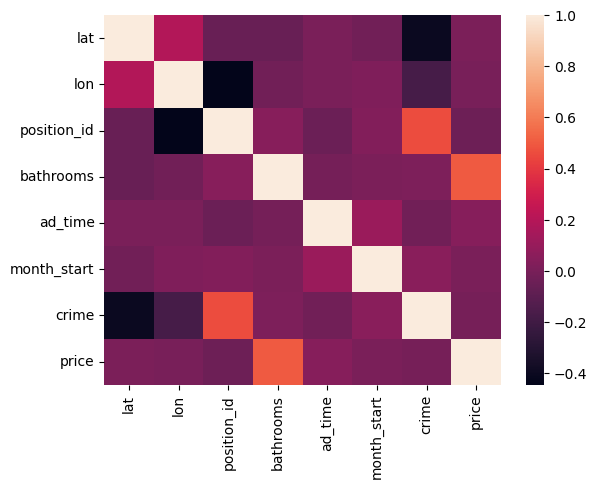

In [88]:
qlt = ['lat','lon','position_id', 'bathrooms', 'ad_time','month_start', 'crime','price']
#correlaciones
sns.heatmap(data=X[qlt].corr());

Parece que el número de baños es el que tiene mayor correlación con la variable de precio.

## Prueba de modelos

In [107]:
# Herramientas para el entrenamiento
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import TruncatedSVD

# Importamos los modelos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Métricas
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score

### Selección de variables
Vemos las variables donde quedaron valores faltantes

In [108]:
X.isnull().mean()*100

lat              0.000000
lon              0.000000
l2               0.000000
l3               5.535761
bathrooms        0.000000
price            0.000000
property_type    0.000000
geometry         0.000000
ad_time          0.000000
month_start      0.000000
position_id      0.000000
crime            0.000000
dtype: float64

Por ahora, no vamos a utilizar `l2` y `l3`.

In [109]:
X_train = X[['lat','lon','position_id','property_type','price','month_start','bathrooms','crime']].copy()
X_train.head()

,lat,lon,position_id,property_type,price,month_start,bathrooms,crime
1,4.722748,-74.073115,0,Apartamento,625000000.0,9,2,2068
2,4.709000,-74.030000,0,Casa,420000000.0,8,2,2068
4,7.154030,-75.503349,2,Apartamento,210000000.0,10,2,2328
5,5.049009,-75.506802,0,Apartamento,167952300.0,12,2,1914
7,10.990806,-74.821082,1,Apartamento,184000000.0,11,2,1743


Creamos la variable target.

In [110]:
X_train['target'] = np.where(X_train['price']>=X_train.price.mean(), 1, 0)
X_train.head()

,lat,lon,position_id,property_type,price,month_start,bathrooms,crime,target
1,4.722748,-74.073115,0,Apartamento,625000000.0,9,2,2068,1
2,4.709000,-74.030000,0,Casa,420000000.0,8,2,2068,1
4,7.154030,-75.503349,2,Apartamento,210000000.0,10,2,2328,0
5,5.049009,-75.506802,0,Apartamento,167952300.0,12,2,1914,0
7,10.990806,-74.821082,1,Apartamento,184000000.0,11,2,1743,0


Creamos una función para obtener los dummies de `property_type`

In [111]:
def property_type_dummies(df):
    df[['Apartamento','Casa','Finca','Local comercial','Lote','Oficina','Otro','Parqueadero']] = pd.get_dummies(df.property_type)
    df.drop('property_type',axis='columns', inplace=True)

    return None

In [112]:
property_type_dummies(X_train)
# Obtenemos los dummies de las demás variables categóricas
#X_train[['id_1','id_2','id_3', 'id_4']] = pd.get_dummies(X_train.position_id)
#X_train[['month_7','month_8','month_9', 'month_10', 'month_11', 'month_12']] = pd.get_dummies(X_train.month_start)

X_train.head()

,lat,lon,position_id,price,month_start,bathrooms,crime,target,Apartamento,Casa,Finca,Local comercial,Lote,Oficina,Otro,Parqueadero
1,4.722748,-74.073115,0,625000000.0,9,2,2068,1,1,0,0,0,0,0,0,0
2,4.709000,-74.030000,0,420000000.0,8,2,2068,1,0,1,0,0,0,0,0,0
4,7.154030,-75.503349,2,210000000.0,10,2,2328,0,1,0,0,0,0,0,0,0
5,5.049009,-75.506802,0,167952300.0,12,2,1914,0,1,0,0,0,0,0,0,0
7,10.990806,-74.821082,1,184000000.0,11,2,1743,0,1,0,0,0,0,0,0,0


Se probaron varias de las variables, pero esta fue la combinación que empíricamente dio mejores resultados.

In [113]:
y_train = X_train.target
X_train = X_train[['lat', 'lon','bathrooms','Apartamento','Casa','Finca','Local comercial','Lote','Oficina','Otro','Parqueadero',]]
X_train.shape

(178223, 11)

In [96]:
X_train_split, X_test, y_train_split, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

### Prueba con varios modelos

In [97]:
clfs = [
    (None, RandomForestClassifier(random_state=15)), 
    (None, GradientBoostingClassifier(random_state=13)),
    (None, DecisionTreeClassifier(random_state=49)), 
    (StandardScaler(), LogisticRegression(random_state=7)),  
#   (StandardScaler(), SVC(random_state=5)), 
    (StandardScaler(), KNeighborsClassifier()), 
    (Normalizer() ,GaussianNB())
    ]

In [98]:
names = []
accuracy = []
recall = []
for scaler, clf in clfs:
    name = clf.__class__.__name__

    if scaler:
        clf = Pipeline(steps=[('ss', scaler), ('clf', clf)])

    # entrenamiento
    clf.fit(X_train_split, y_train_split)

    # predicción
    pred = clf.predict(X_test)

    # métricas
    acc = accuracy_score(y_test, pred)*100
    rec = recall_score(y_test, pred)*100
    
    # Guardamos los puntajes
    names.append(name)
    accuracy.append(acc)
    recall.append(rec)

    print('*'*5,name,'*'*5) 
    print('accuracy: ', round(acc,2))
    print('recall: ', round(rec,2))

***** RandomForestClassifier *****
accuracy:  88.04
recall:  80.58
***** GradientBoostingClassifier *****
accuracy:  79.82
recall:  63.28
***** DecisionTreeClassifier *****
accuracy:  87.4
recall:  79.49
***** LogisticRegression *****
accuracy:  75.23
recall:  48.72
***** KNeighborsClassifier *****
accuracy:  85.01
recall:  76.96
***** GaussianNB *****
accuracy:  69.99
recall:  36.5


Probamos reduciendo dimensiones

In [64]:
names = []
accuracy = []
recall = []
for scaler, clf in clfs:
    name = clf.__class__.__name__

    if scaler:
        clf = Pipeline(steps=[('ss', scaler), ('dr', TruncatedSVD(n_components=5, n_iter=3, random_state=42)), ('clf', clf)])

    # entrenamiento
    clf.fit(X_train_split, y_train_split)

    # predicción
    pred = clf.predict(X_test)

    # métricas
    acc = accuracy_score(y_test, pred)*100
    rec = recall_score(y_test, pred)*100
    
    # Guardamos los puntajes
    names.append(name)
    accuracy.append(acc)
    recall.append(rec)

    print('*'*5,name,'*'*5) 
    print('accuracy: ', round(acc,2))
    print('recall: ', round(rec,2))

***** RandomForestClassifier *****
accuracy:  88.09
recall:  80.72
***** GradientBoostingClassifier *****
accuracy:  79.65
recall:  63.53
***** DecisionTreeClassifier *****
accuracy:  87.32
recall:  79.5
***** LogisticRegression *****
accuracy:  69.4
recall:  35.76
***** SVC *****
accuracy:  76.41
recall:  58.11
***** KNeighborsClassifier *****
accuracy:  84.7
recall:  76.43
***** GaussianNB *****
accuracy:  70.57
recall:  41.56


Con los mejores tres modelos hacemos crossvalidation para obtener las métricas con error.

In [66]:
clfs = [
    (None, RandomForestClassifier(random_state=15)), 
    (None, DecisionTreeClassifier(random_state=49)),
    (StandardScaler(), KNeighborsClassifier())
]

In [67]:
# Kfold crossvalidation
for scaler, clf in clfs:
    name = clf.__class__.__name__
    if scaler:
        clf = Pipeline(steps=[('ss', scaler), ('clf', clf)])
    _scoring = ['accuracy', 'recall']
    results = cross_validate(estimator=clf,
                        X=X_train,
                        y=y_train,
                        cv=5,
                        scoring=_scoring,
                        return_train_score=True)
    print('*'*5,name,'*'*5) 
    print('accuracy: ', round(results['train_accuracy'].mean()*100,2),' ± ',round(results['train_accuracy'].std()*100,3))
    print('recall: ',  round(results['train_recall'].mean()*100,2), ' ± ', round(results['train_recall'].std()*100,3))
    print('')


***** RandomForestClassifier *****
accuracy:  93.9  ±  0.024
recall:  89.27  ±  0.105

***** DecisionTreeClassifier *****
accuracy:  93.9  ±  0.025
recall:  88.72  ±  0.096

***** KNeighborsClassifier *****
accuracy:  86.88  ±  2.5
recall:  82.6  ±  1.479



El mejor modelo de los tres probados anteriormente fue random forest. Voy a hacer un grid search para buscar los parámetros que maximicen el recall:

In [ ]:
#clf = RandomForestClassifier(random_state=49)

#param_grid = { 
#    'n_estimators': [200, 500],
#    'max_features': ['sqrt', 'log2'],
#    'max_depth' : [4,5,6,7,8],
#    'criterion' :['gini', 'entropy']
#}

#GS_clf = GridSearchCV(estimator=clf, param_grid=param_grid, scoring = 'recall', cv= 5)
#GS_clf.fit(X_train, y_train);

In [81]:
#GS_clf.best_params_
# Resultado
# {'criterion': 'gini',
# 'max_depth': 8,
# 'max_features': 'auto',
# 'n_estimators': 500}

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

Las predicciones con estos parámetros resultaron en el peor modelo.

## Predicciones
El mejor modelo fue el random forest y es el que vamos a usar para predecir. Primero, cargamos los datos de test y realizamos las transformaciones pertinentes de las columnas:

In [122]:
X_test = pd.read_csv('datasets/properties_colombia_test.csv')
X_test.head()

,Unnamed: 0,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,...,bathrooms,surface_total,surface_covered,currency,price_period,title,description,property_type,operation_type,geometry
0,852569,pCiVu6rxpBq9dCZfYCXXgA==,Propiedad,2020-09-04,2020-09-12,2020-09-04,4.722000,-74.075000,Colombia,Cundinamarca,...,3.0,660.0,350.0,COP,NaN,Casa En Arriendo/venta En Bogota Sotileza Cod....,"EXCLUSIVA CASA EN VENTA Y ARRIENDO, UBICADA EN...",Casa,Venta,POINT (-74.075 4.722)
1,121379,L0XSQ7mF1TWb1lHRg4n2+A==,Propiedad,2020-10-20,2020-10-20,2020-10-20,NaN,NaN,Colombia,Antioquia,...,3.0,NaN,NaN,COP,Mensual,SE VENDE APARTAMENTO EN EL SECTOR DE ZUÑIGA-EN...,"PR 7555. Apartamento Duplex en unidad cerrada,...",Apartamento,Venta,POINT EMPTY
2,119504,FbWRxZOMNoUzVOLXgkum1A==,Propiedad,2020-10-20,2020-10-22,2020-10-20,6.259253,-75.628381,Colombia,Antioquia,...,1.0,NaN,NaN,COP,NaN,Casa Barata San Javier Solo por este mes,"Casa compraventa escrituras en \n proceso,sala...",Casa,Venta,POINT (-75.6283806 6.25925267)
3,227304,RUV1P+3UOmNdlJ9fBdWFyw==,Propiedad,2020-12-10,9999-12-31,2020-12-10,6.203000,-75.556000,Colombia,Antioquia,...,NaN,2793.0,NaN,COP,NaN,Lote En Venta En Medellin La Calera Cod. VRPR6330,CODIGO 6330LOTE PARA LA VENTA DE 2793MTS,Lote,Venta,POINT (-75.556 6.203)
4,228600,ifKutEAhyovuDNeYrFFV+A==,Propiedad,2020-12-10,2020-12-11,2020-12-10,NaN,NaN,Colombia,Antioquia,...,2.0,NaN,NaN,COP,NaN,Casa en Venta Ubicado en MEDELLIN,Codigo Inmueble 505457 Casa en venta en el sec...,Casa,Venta,POINT EMPTY


Eliminamos las columnas que no utilizamos

In [123]:
X_test.drop(['Unnamed: 0', 'id', 'ad_type', 'start_date', 'end_date', 'created_on',
            'l1', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms',
            'surface_total', 'surface_covered', 'currency', 'price_period', 
            'title', 'operation_type', 'geometry'], axis='columns', inplace=True)

X_test.columns

Index(['lat', 'lon', 'l2', 'bathrooms', 'description', 'property_type'], dtype='object')

In [124]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65850 entries, 0 to 65849
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lat            49433 non-null  float64
 1   lon            49433 non-null  float64
 2   l2             65850 non-null  object 
 3   bathrooms      52054 non-null  float64
 4   description    65823 non-null  object 
 5   property_type  65850 non-null  object 
dtypes: float64(3), object(3)
memory usage: 3.0+ MB


Nos aseguramos que las coordenadas estén dentro de Colombia

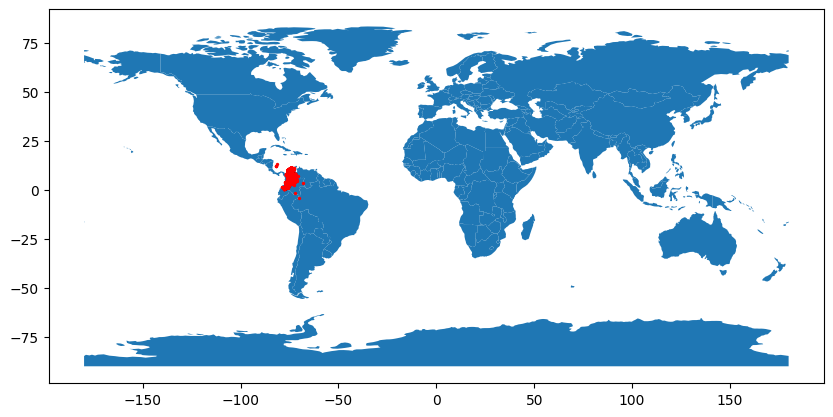

In [125]:
X_geo = X_test.copy()
geometry = [Point(xy) for xy in zip(X_geo['lon'], X_geo['lat'])]
gdf = GeoDataFrame(X_geo, geometry=geometry)    

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=2);

Chequeamos las variables categóricas:

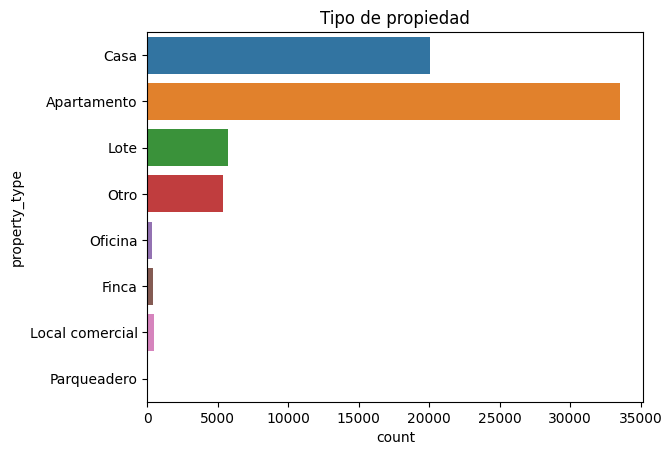

In [126]:
sns.countplot(data=X_test, y='property_type')
plt.title('Tipo de propiedad');

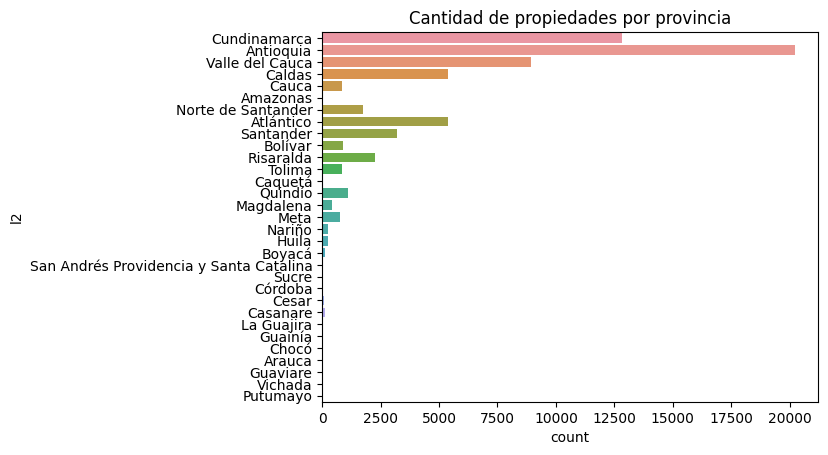

In [127]:
sns.countplot(data=X_test, y='l2')
plt.title('Cantidad de propiedades por provincia');

Las distribuciones son similares a las del set de entrenamiento. Ahora podemos limpiar los datos de prueba:

In [117]:
# Realizamos las mismas transformaciones que al training set
# Rellenamos los valores faltantes de latitud y longitud
fill_lat_lon(X_test)
# Obtenemos el numero de baños con las descripciones o con la moda
X_test = get_number_bathrooms(X_test)
# Creamos las variables dummies de tipo de propiedad
property_type_dummies(X_test)
# Eliminamos las columnas que no vamos a usar en el training
X_test.drop(['l2','description'], axis='columns', inplace=True)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65850 entries, 0 to 65849
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lat              65850 non-null  float64
 1   lon              65850 non-null  float64
 2   bathrooms        65850 non-null  int32  
 3   Apartamento      65850 non-null  uint8  
 4   Casa             65850 non-null  uint8  
 5   Finca            65850 non-null  uint8  
 6   Local comercial  65850 non-null  uint8  
 7   Lote             65850 non-null  uint8  
 8   Oficina          65850 non-null  uint8  
 9   Otro             65850 non-null  uint8  
 10  Parqueadero      65850 non-null  uint8  
dtypes: float64(2), int32(1), uint8(8)
memory usage: 1.8 MB


In [118]:
clf = Pipeline(steps=[('ss', StandardScaler()), ('clf', RandomForestClassifier(random_state=15))])
clf.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('clf', RandomForestClassifier(random_state=15))])

In [119]:
pred_test = clf.predict(X_test)

In [120]:
pred = pd.Series(pred_test) 
pred = pred.rename('pred')
pred.to_csv('marianaiv.csv', index=False)